# Для твоих вопросов или комментариев оставлю такую ячейку, чтобы было удобнее взаимодействовать на проекте

# Интернет магазин "Стримчик"

В рамкахках данного исследования, на основе данных интернет-магазина, мы попробуем выявить факторы влияния на успешность игры у покупателей. 

## Подготовка данных

In [279]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [280]:
data=pd.read_csv('/datasets/games.csv')

In [281]:
#посмотрим на данные
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Формат данных

In [282]:
data.columns=data.columns.str.lower()

In [283]:
#преобразование типов
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [284]:
#год - целое число
data['year_of_release'] = data['year_of_release'].astype("Int64") 
#оценка игроков - числовое значение

In [285]:
#текстовое значение мешается, но при этом необходимо будет отдельно посомтреть на записи с значением 'tbd', 
#поэтому заменим строку на числовое, заранее невозможное значение.
print(data[data['user_score'] == 'tbd'].shape)
data.loc[data['user_score'] == 'tbd', 'user_score'] = '999'
print(data[data['user_score'] == '999'].shape)

(2424, 11)
(2424, 11)


In [286]:
data['user_score'] = data['user_score'].astype("float64") 

In [287]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


- "Год релиза" заменяем на целое число
- "Оценка игроков" должна иметь числовой формат

### Замена пропусков

In [288]:
data.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [289]:
data[data['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Название отсутвует всего у 2 записей. У этих же записей не заполнен жанр. Т.к. условно, мы исследуем рынок 2016 года, пару записей от 1993 года можно удалить

In [290]:
data.dropna(subset=['name'],inplace=True)

In [291]:
# посмотрим на записи с пропущенным годом релиза
data[data['year_of_release'].isnull()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


У части записей можно восстановить год релиза по названию. Попробуем.

In [292]:
data[(data['name'].str[-4:].str.isdigit()) & (data['year_of_release'].isnull())]['name'].shape

(15,)

Только 15 строк можно восстановить, что мало. Т.к. год важный признак для последующего анализа, все записи с пропусками удаляем

In [293]:
data.dropna(subset=['year_of_release'],inplace=True)

Теперь попробуем разобраться со значенгиями TBD в оценке пользователей (ранее заменено на значение 999). Для этого посмотрим на взаимосвязь с другими стобцами.

In [294]:
data[data['user_score']==999].pivot_table(index=['rating'], columns='year_of_release', values='user_score', aggfunc='count')

year_of_release,1997,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
rating,,,,,,,,,,,,,,,,,,,
E,NaN,7.0,36.0,72.0,138.0,59.0,73.0,72.0,77.0,128.0,231.0,282.0,200.0,118.0,15.0,11.0,8.0,15.0,6.0
E10+,NaN,NaN,NaN,NaN,NaN,NaN,1.0,27.0,26.0,37.0,51.0,60.0,66.0,54.0,4.0,3.0,9.0,9.0,13.0
EC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN
M,NaN,1.0,1.0,1.0,4.0,4.0,7.0,2.0,1.0,3.0,2.0,4.0,4.0,3.0,1.0,NaN,NaN,NaN,4.0
T,1.0,NaN,4.0,8.0,49.0,32.0,25.0,19.0,18.0,23.0,37.0,52.0,51.0,32.0,1.0,1.0,2.0,7.0,7.0


In [295]:
data[data['user_score']==999].pivot_table(index=['platform'], columns='year_of_release', values='user_score', aggfunc='count')

year_of_release,1997,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,
3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,4.0,4.0,9.0,9.0,3.0
DS,NaN,NaN,NaN,NaN,NaN,NaN,1.0,17.0,35.0,103.0,183.0,186.0,144.0,62.0,8.0,5.0,NaN,NaN,NaN
GBA,NaN,NaN,NaN,44.0,83.0,36.0,48.0,37.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GC,NaN,NaN,NaN,2.0,36.0,19.0,15.0,18.0,8.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PC,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,2.0,2.0,7.0,11.0,6.0,13.0,NaN,NaN,1.0,2.0,2.0
PS,1.0,7.0,27.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PS2,NaN,NaN,16.0,21.0,35.0,11.0,14.0,15.0,18.0,31.0,43.0,22.0,9.0,1.0,NaN,NaN,NaN,NaN,NaN
PS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,7.0,12.0,16.0,23.0,3.0,1.0,5.0,11.0,6.0
PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0


In [296]:
data[data['user_score']==999].pivot_table(index=['genre'], columns='year_of_release', values='user_score', aggfunc='count')

year_of_release,1997,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
genre,,,,,,,,,,,,,,,,,,,
Action,NaN,NaN,2.0,8.0,27.0,20.0,27.0,20.0,18.0,27.0,35.0,54.0,49.0,33.0,5.0,3.0,9.0,25.0,6.0
Adventure,NaN,1.0,1.0,3.0,6.0,NaN,3.0,4.0,6.0,20.0,32.0,35.0,23.0,9.0,3.0,1.0,5.0,1.0,3.0
Fighting,NaN,NaN,3.0,1.0,8.0,1.0,2.0,2.0,2.0,4.0,4.0,4.0,3.0,NaN,1.0,NaN,NaN,1.0,1.0
Misc,NaN,1.0,1.0,3.0,13.0,8.0,11.0,34.0,20.0,31.0,63.0,85.0,74.0,77.0,6.0,1.0,NaN,2.0,10.0
Platform,NaN,NaN,1.0,8.0,16.0,11.0,11.0,25.0,16.0,7.0,11.0,10.0,7.0,5.0,NaN,3.0,NaN,1.0,3.0
Puzzle,NaN,1.0,2.0,7.0,8.0,3.0,6.0,9.0,18.0,25.0,39.0,35.0,27.0,21.0,3.0,NaN,2.0,1.0,1.0
Racing,NaN,1.0,9.0,16.0,37.0,26.0,14.0,13.0,12.0,13.0,19.0,32.0,17.0,17.0,NaN,NaN,2.0,1.0,NaN
Role-Playing,NaN,NaN,NaN,3.0,2.0,2.0,1.0,NaN,NaN,6.0,7.0,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
Shooter,1.0,1.0,2.0,4.0,13.0,8.0,13.0,2.0,6.0,5.0,6.0,6.0,15.0,6.0,NaN,2.0,1.0,NaN,4.0


Игры выпускались в разныпе годы, на разные платформы и различных жанров. Считаю, что корректнее заменить значение на null

In [297]:
data.loc[data['user_score'] == 999, 'user_score'] = np.nan

In [298]:
#Заполнение пропущенных значений
#Рейтинг
data[data['rating'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Причины пропусков в рейтинге:
- ESRB появилась в 1994 году. Игры, релиз которых, был ранее 1994 года могут остаться без рейтинга
- Рейтинг обязателен для игр в северной америке. Игры, которые выходили в других регионах могут быть без рейтинга
- До начала официальных продаж в США и Канаде рейтинг игре не присваивается

In [299]:
#Оценка критиков
data[data['critic_score'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Причины пропусков в "оценке критиков":
- Нет какой-то единой огранизации цель которых выставлять оценки иргам. Отсюда следует, что показатель далеко не обязателен.
- На ранних этапах игровой сферы, не было такого понятия "оценка критиков"
- Игры ещё не вышедшие, тоже будут без оценок

In [300]:
#Оценка играков
data[data['user_score'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Причины пропусков в "оценке игроков":
- Оценки могли не ставиться на ранних этапах игровой индустрии
- Игры, которые не вышли, останутся без оценок

Пропусков в оценках критиков, оценках игроков и рейтинге очень много, до 30% всех записей, поэтому мы не будем удалять данные строки. 

In [301]:
#посчитаем общие продажи
data['all_sales']=data['na_sales']+data['eu_sales']+data['jp_sales']+data['other_sales']

Проверим ограничения на оценки критиков и оценки игроков

<AxesSubplot:>

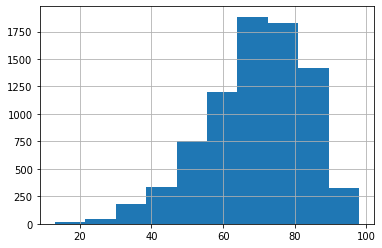

In [302]:
data['critic_score'].hist(bins=10)

<AxesSubplot:>

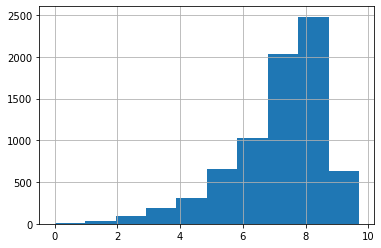

In [303]:
data['user_score'].hist(bins=10)

In [304]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
 11  all_sales        16444 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB


In [305]:
data.pivot_table(index=['rating'], values='name', aggfunc='count')

,name
rating,
AO,1
E,3921
E10+,1393
EC,8
K-A,3
M,1536
RP,1
T,2905


In [306]:
data.loc[data['rating'].isna(),'rating']='M'

In [307]:
data.pivot_table(index=['rating'], values='name', aggfunc='count')

,name
rating,
AO,1
E,3921
E10+,1393
EC,8
K-A,3
M,8212
RP,1
T,2905


## Исследуем данные

### Отбор периода

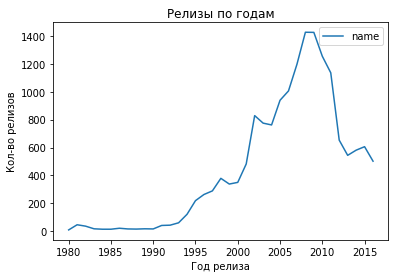

In [308]:
data.pivot_table(index=['year_of_release'], values='name', aggfunc='count').plot(kind='line', title='Релизы по годам')
plt.xlabel("Год релиза")
plt.ylabel("Кол-во релизов")
plt.show()

In [309]:
# продажи по платформам
data.pivot_table(index=['platform'],  values='name', aggfunc='count').sort_values(by='name', ascending=False)

,name
platform,
PS2,2127
DS,2121
PS3,1306
Wii,1286
X360,1232
PSP,1193
PS,1190
PC,957
GBA,811


In [310]:
#Установим отсечку на 200 играх
top_platform=data.pivot_table(index=['platform'],  values='name', aggfunc='count')[data.pivot_table(index=['platform'],  \
                                                                                    values='name', aggfunc='count')['name']>200]

In [311]:
#отберём данные по платформам из TOP
top_platform_data=data.query('platform in @top_platform.index')

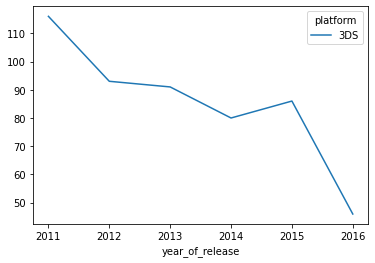

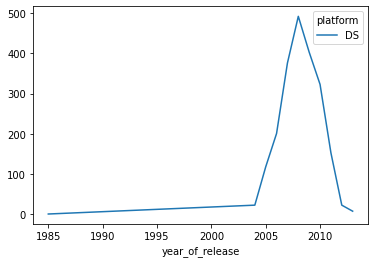

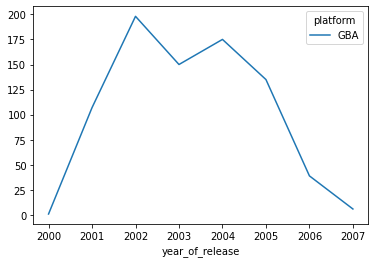

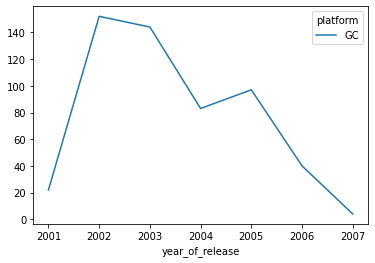

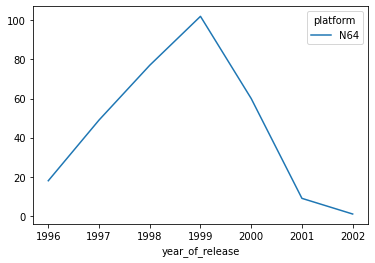

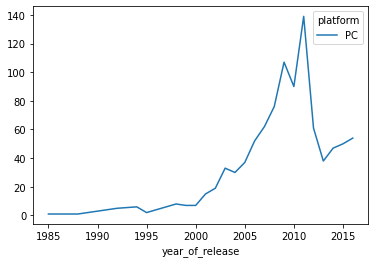

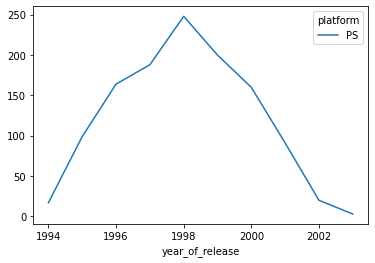

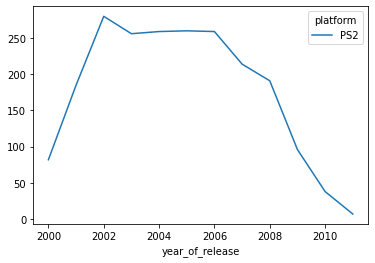

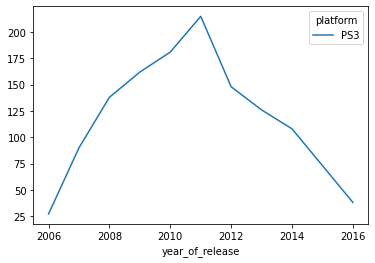

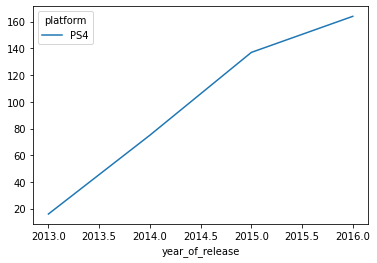

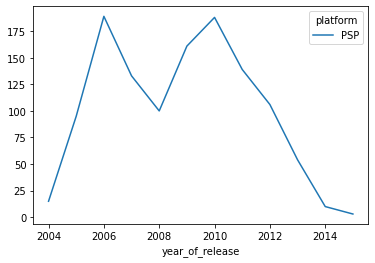

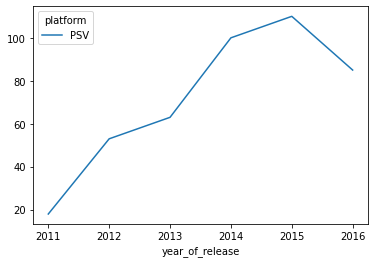

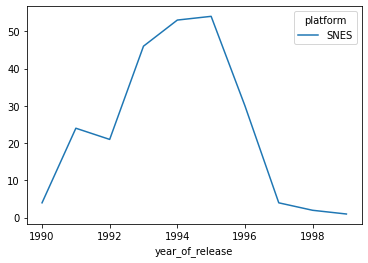

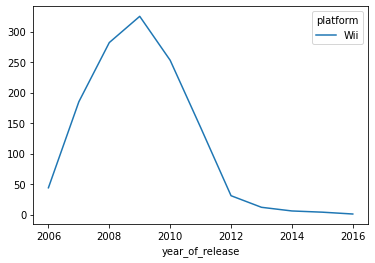

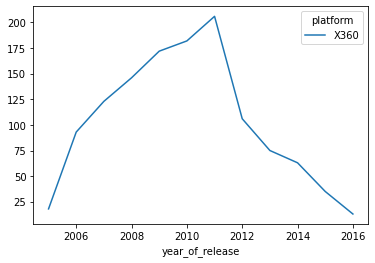

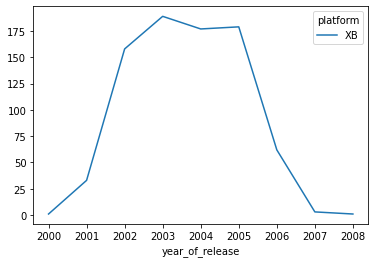

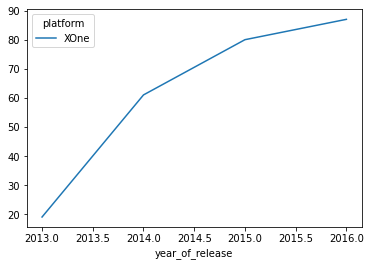

In [312]:
for platform in top_platform.index:
    top_platform_data[top_platform_data['platform']==platform].pivot_table(index=['year_of_release'], \
                                                                columns='platform', values='name', aggfunc='count').plot.line()

В зависимости от платформы, от 6 до 10 лет появляются и теряют актуальность платформы. Для дальнейшего анализа будем использовать интервал в 6 лет.

In [313]:
data[data['platform']=='DS'].pivot_table(index=['platform'], columns='year_of_release', values='name', aggfunc='count')

year_of_release,1985,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
platform,,,,,,,,,,,
DS,1,23,118,201,376,492,403,323,153,23,8


Данные за 1985 год - это ошибка, т.к. платформа появилась в начале 2000-х. Данную анамалию не будем учитывать в полследующем, т.к. мы возьмём только короткий интермал данных для прогнозирования.

In [314]:
actual_data=data[data['year_of_release']>2009]

In [315]:
actual_data=data[data['year_of_release']>2013]

### Отбор платформ

In [316]:
actual_data.pivot_table(index=['platform'], columns='year_of_release', values='user_score', aggfunc='count')

year_of_release,2014,2015,2016
platform,,,
3DS,22.0,21.0,12.0
PC,38.0,39.0,45.0
PS3,63.0,26.0,9.0
PS4,52.0,89.0,101.0
PSP,0.0,0.0,NaN
PSV,37.0,23.0,13.0
Wii,2.0,0.0,0.0
WiiU,19.0,20.0,9.0
X360,52.0,24.0,7.0


К потенциально прибыльным платформам можно отнести:
- PC
- PS4
- XOne
- PS3
- 3DS

In [317]:
actual_platform=['PC', 'PS4','XOne','PS3','3DS']

In [318]:
actual_platform_data=actual_data.query('platform in @actual_platform')

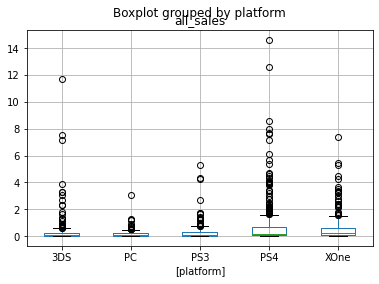

In [319]:
#посомтрим на продажи в разрезе потенциальных платформ
actual_platform_data.boxplot(column=['all_sales'], by = ['platform'])
plt.show()

(0.0, 2.0)

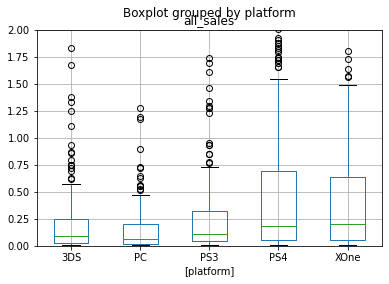

In [320]:
actual_platform_data.boxplot(column=['all_sales'], by = ['platform'])
plt.ylim(0, 2)

В рассматриваемом периоде:
- Игры на PC продаются хуже чем на приставках
- На всех платформах есть выбросы с очень высокими объёмами продаж
- Распределение на всех платформах сильно скошено вправо

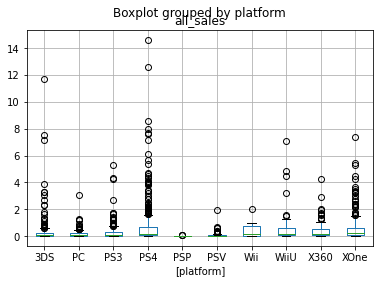

In [321]:
actual_data.boxplot(column=['all_sales'], by = ['platform'])
plt.show()

(0.0, 1.0)

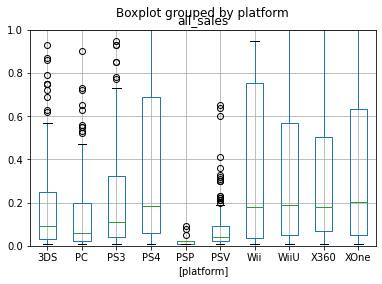

In [322]:
actual_data.boxplot(column=['all_sales'], by = ['platform'])
plt.ylim(0, 1)

В рассматриваемом периоде:
- PSP и PSV аутсайдеры данного списка
- PC сильно отстаёт от игровых приставок
- У 3DS, PS4 и XOne много игр с выбросами по высокому объёму продаж

### Влияние на продажи

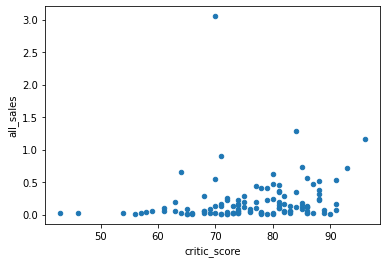

Корреляция между объёмом продаж и оценкой критиков = 0.17463413769350036


In [323]:
#Начнём с платформы PC
actual_platform_data[actual_platform_data['platform']=='PC'].plot.scatter(y='all_sales',x='critic_score')
plt.show()
print('Корреляция между объёмом продаж и оценкой критиков =',actual_platform_data[actual_platform_data['platform']=='PC']['all_sales'].corr(actual_platform_data[actual_platform_data['platform']=='PC']['critic_score']))

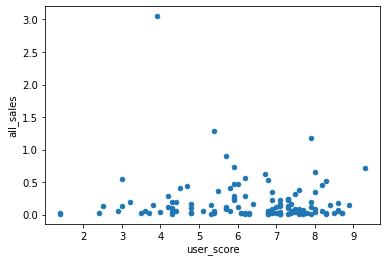

Корреляция между объёмом продаж и оценкой игроков = -0.07159665703472452


In [324]:
actual_platform_data[actual_platform_data['platform']=='PC'].plot.scatter(y='all_sales',x='user_score')
plt.show()
print('Корреляция между объёмом продаж и оценкой игроков =',actual_platform_data[actual_platform_data['platform']=='PC']['all_sales'].corr(actual_platform_data[actual_platform_data['platform']=='PC']['user_score']))

- взимосвязь между объёмом продаж  и оценкой критиков, прямая, но слабая
- взимосвязь между объёмом продаж  и оценкой играков отсутствует

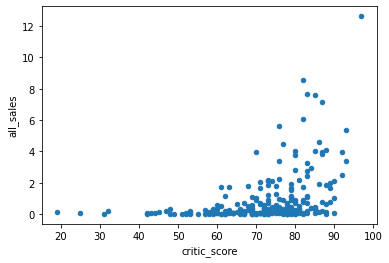

Корреляция между объёмом продаж и оценкой критиков = 0.40266141068104083


In [325]:
#PS4
actual_platform_data[actual_platform_data['platform']=='PS4'].plot.scatter(y='all_sales',x='critic_score')
plt.show()
print('Корреляция между объёмом продаж и оценкой критиков =',actual_platform_data[actual_platform_data['platform']=='PS4']['all_sales'].corr(actual_platform_data[actual_platform_data['platform']=='PS4']['critic_score']))

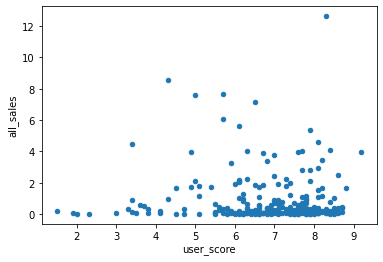

Корреляция между объёмом продаж и оценкой игроков = -0.040131589472697356


In [326]:
actual_platform_data[actual_platform_data['platform']=='PS4'].plot.scatter(y='all_sales',x='user_score')
plt.show()
print('Корреляция между объёмом продаж и оценкой игроков =',actual_platform_data[actual_platform_data['platform']=='PS4']['all_sales'].corr(actual_platform_data[actual_platform_data['platform']=='PS4']['user_score']))

Аналогично платформе PC:
- взимосвязь между объёмом продаж  и оценкой критиков, прямая, но слабая
- взимосвязь между объёмом продаж  и оценкой играков отсутствует

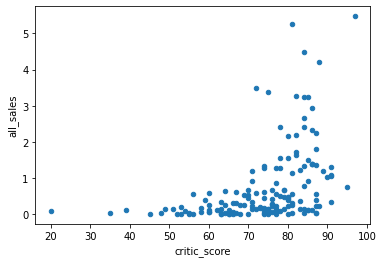

Корреляция между объёмом продаж и оценкой критиков = 0.42867694370333226


In [327]:
#PS4
actual_platform_data[actual_platform_data['platform']=='XOne'].plot.scatter(y='all_sales',x='critic_score')
plt.show()
print('Корреляция между объёмом продаж и оценкой критиков =',actual_platform_data[actual_platform_data['platform']=='XOne']['all_sales'].corr(actual_platform_data[actual_platform_data['platform']=='XOne']['critic_score']))

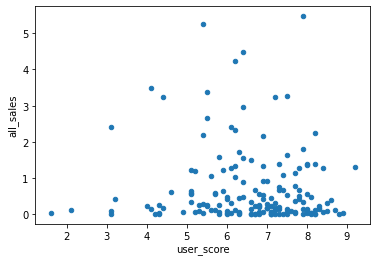

Корреляция между объёмом продаж и оценкой игроков = -0.0703839280647581


In [328]:
actual_platform_data[actual_platform_data['platform']=='XOne'].plot.scatter(y='all_sales',x='user_score')
plt.show()
print('Корреляция между объёмом продаж и оценкой игроков =',actual_platform_data[actual_platform_data['platform']=='XOne']['all_sales'].corr(actual_platform_data[actual_platform_data['platform']=='XOne']['user_score']))

Можно сделать вывод для всех платформ:
- взимосвязь между объёмом продаж  и оценкой критиков, прямая, но слабая
- взимосвязь между объёмом продаж  и оценкой играков отсутствует

In [329]:
actual_platform_data.pivot_table(index=['genre'], columns='year_of_release', values='all_sales', aggfunc='sum')

year_of_release,2014,2015,2016
genre,,,
Action,78.58,63.64,25.96
Adventure,3.50,6.20,3.26
Fighting,9.98,7.67,3.34
Misc,17.03,6.67,1.40
Platform,7.13,0.80,2.91
Puzzle,0.23,0.70,NaN
Racing,7.89,8.01,2.79
Role-Playing,39.85,34.66,16.55
Shooter,53.27,60.73,37.81


В топе продаж игры со следующими жанрами:
- Action
- Shooter
- Sports

<AxesSubplot:title={'center':'all_sales'}, xlabel='[genre]'>

<Figure size 1080x288 with 0 Axes>

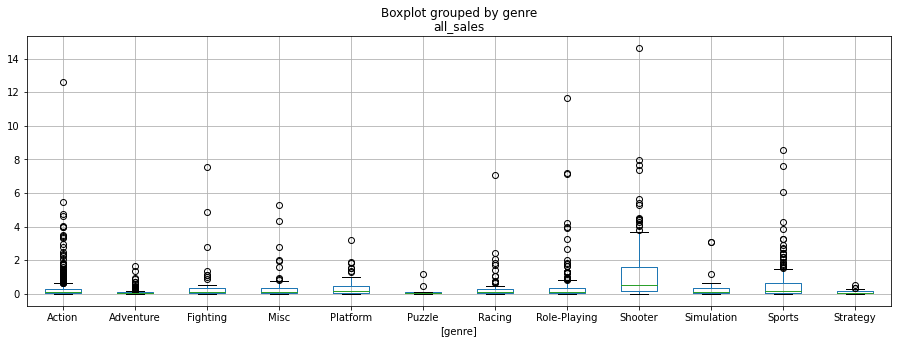

In [330]:
plt.figure(figsize=(15,4))
actual_data.boxplot(column=['all_sales'], by = ['genre'],figsize=(15, 5))

(0.0, 2.0)

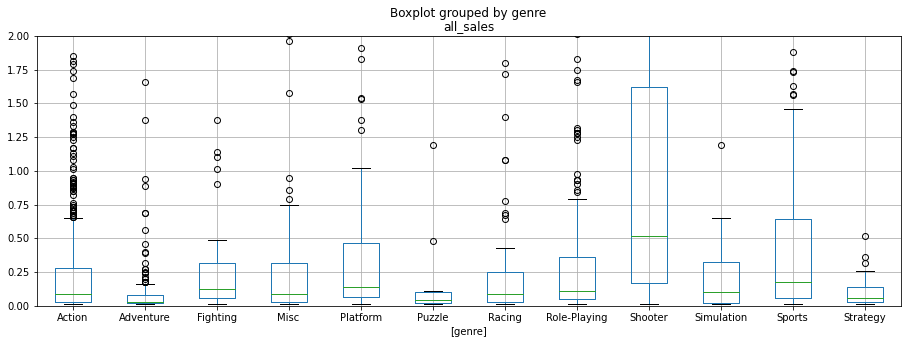

In [331]:
actual_data.boxplot(column=['all_sales'], by = ['genre'],figsize=(15, 5))
plt.ylim(0, 2)

## Портрет пользователей

### Популярные платформы и жанры по регионам

In [332]:
actual_data.pivot_table(index=['platform'], values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head()

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05


In [333]:
actual_data.pivot_table(index=['platform'], values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head()

,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12


In [334]:
actual_data.pivot_table(index=['platform'], values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head()

,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31


Регионы различаются по платформам:
- В японии xbox вовсе не попадают в топ, и есть своя уникальная 3DS.
- В европе в топ папал PC. Европейский топ более похож на американский.
- В америке более популярны приставки xbox, чем в других регионах
- Приставки PS в топе во всех регионах

In [335]:
actual_data.pivot_table(index=['genre'], values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head()

,na_sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05


In [336]:
actual_data.pivot_table(index=['genre'], values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head()

,eu_sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13


In [337]:
actual_data.pivot_table(index=['genre'], values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head()

,jp_sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87


В части жанров:
- америка и европа более схожи между собой
- япония выделяется тем, что самый популярный жанр это РПГ, а шутинги и спортивыне игры вовсе не попали в топ.
- причина столь сильного отличия японии от других рынков, может заключаться в отличие по палтформам и различиями в культуре.

In [358]:
#Создадим вспомагательные столбцы
platform_top_us=actual_data.pivot_table(index=['platform'], values='na_sales', aggfunc='sum').\
    sort_values(by='na_sales', ascending=False).head(5)
platform_top_eu=actual_data.pivot_table(index=['platform'], values='eu_sales', aggfunc='sum').\
    sort_values(by='eu_sales', ascending=False).head(5)
platform_top_jp=actual_data.pivot_table(index=['platform'], values='jp_sales', aggfunc='sum').\
    sort_values(by='jp_sales', ascending=False).head(5)
actual_data['platform_cat_us'] = actual_data['platform'].apply(lambda x: x if x in platform_top_us.index else 'other')
actual_data['platform_cat_eu'] = actual_data['platform'].apply(lambda x: x if x in platform_top_eu.index else 'other')
actual_data['platform_top_jp'] = actual_data['platform'].apply(lambda x: x if x in platform_top_jp.index else 'other')

/tmp/ipykernel_31/871629206.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['platform_cat_us'] = actual_data['platform'].apply(lambda x: x if x in platform_top_us.index else 'other')
/tmp/ipykernel_31/871629206.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actual_data['platform_cat_eu'] = actual_data['platform'].apply(lambda x: x if x in platform_top_eu.index else 'other')
/tmp/ipykernel_31/871629206.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [364]:
actual_data.pivot_table(index=['platform_cat_us'], values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)

,na_sales
platform_cat_us,
PS4,98.61
XOne,81.27
other,31.19
X360,28.30
3DS,22.64
PS3,22.05


In [361]:
actual_data.pivot_table(index=['platform_cat_eu'], values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)

,eu_sales
platform_cat_eu,
PS4,130.04
XOne,46.25
other,34.76
PS3,25.54
PC,17.97
3DS,16.12


In [362]:
actual_data.pivot_table(index=['platform_top_jp'], values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)

,jp_sales
platform_top_jp,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31
other,0.76


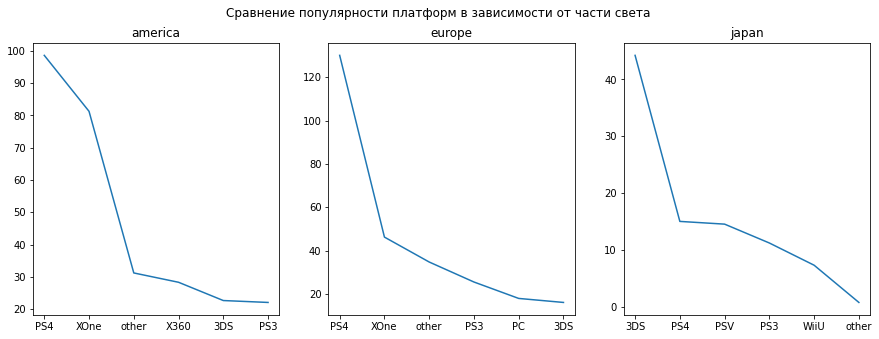

In [391]:
x1 = actual_data.pivot_table(index=['platform_cat_us'], values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).index
y1 = actual_data.pivot_table(index=['platform_cat_us'], values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)['na_sales']


fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=False,
                                    figsize=(15, 5))

ax1.set_title('america')
ax1.plot(x1, y1)
plt.subplot(ax1)

x2 = actual_data.pivot_table(index=['platform_cat_eu'], values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).index
y2 = actual_data.pivot_table(index=['platform_cat_eu'], values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)['eu_sales']

ax2.set_title('europe')
ax2.plot(x2, y2)
plt.subplot(ax2)

x3 = actual_data.pivot_table(index=['platform_top_jp'], values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).index
y3 = actual_data.pivot_table(index=['platform_top_jp'], values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)['jp_sales']

ax3.set_title('japan')
ax3.plot(x3, y3)
plt.subplot(ax3)

fig.suptitle('Сравнение популярности платформ в зависимости от части света')
plt.show()

Выделяется среди регионов япония с платформfvb 3DS, PSV. В европе и америке преобладают приставки нового поколения.

In [338]:
actual_data.pivot_table(index=['rating'], values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head()

,na_sales
rating,
M,161.14
E,50.74
T,38.95
E10+,33.23


In [339]:
actual_data.pivot_table(index=['rating'], values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head()

,eu_sales
rating,
M,152.39
E,58.06
T,34.07
E10+,26.16


In [340]:
actual_data.pivot_table(index=['rating'], values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head()

,jp_sales
rating,
M,64.91
T,14.78
E,8.94
E10+,4.46


При рассмотрении рейтинга так же следует отметить рынок японии, где преобладаю игры "для всех" и "для подростков", в то время как в европе и америке, ТОП 1 - это игры 17+.

### Проверка гипотез

Проверим различается ли пользовательский рейтинг для палтформ Xbox One и PC.

Для обоих проверок применим критерий для проверки равенства средних в 2 генеральных совокупностях.

In [341]:
#Отбираем требуемые данные для критерия
Xbox_data = actual_data.query('platform == "XOne" and not (user_score.isnull())')['user_score']
min_XBO=actual_data.query('platform == "XOne" and not (user_score.isnull())')['year_of_release'].min()
PC_data = actual_data.query('platform == "PC" and not (user_score.isnull()) and year_of_release>=@min_XBO')['user_score']

In [342]:
#Проверяем нулевую гипотезу: среднее по оценке пользователей не различается для платформ Xbox One и PC
#Альтернативная гипотеза: среднее по оценке пользователей различаются для платформ Xbox One и PC
results = st.ttest_ind(
    Xbox_data,
    PC_data)
print('p-значение: ', results.pvalue)

p-значение:  0.10450507919348415


Мы можем отвергнуть нулевую гипотезу с уровнем значимости в 0,11. При меньших alpha мы не можем отвергнуть лулевую гипотезу.

In [343]:
#Теперь проверим различия между жанрами
action_data=actual_data.query('genre == "Action" and not (user_score.isnull())')['user_score']
sports_data=actual_data.query('genre == "Sports" and not (user_score.isnull())')['user_score']

In [344]:
#Проверяем нулевую гипотезу: среднее по оценке пользователей не различается для жанров Action и Sports
#Альтернативная гипотеза: среднее по оценке пользователей различаются для жанров Action и Sports
results = st.ttest_ind(
    action_data,
    sports_data)
print('p-значение: ', results.pvalue)

p-значение:  2.8711147985105864e-19


Очень малое pvalue, которое позволяет нам даже для аровня значимости alpha в 0,001 отвернуть нулевую гипотезу и сказать, что различия в средней оценке для указанных жанров есть.

## Выводы

В рамках текущего исследования мы на данных интернет магазина пытаемся определить успешность игр:
- Данне содержат много пропусков в части оценок критиков и игроков
- Популярность игр зависит от преставленных в рассматриваемом периоде платформ, т.к. платформы появляются и устаревают. Срок "жизни палтформы" в диапазоне от 6 до 10 лет.
- для прогноз продаж на 2017 год достаточно использовать последние 6 лет в представленных данных
- Ориентироваться необходимо на новые платформы или долгоживущие. К таковым относятся: PC, XboxOne, PS4. Продажи в прочих платформах будут снижаться
- мы установили, что между оценко критиком и объёмом продаж есть слабая положительная корреляция, при этом корреляции между объёмом продаж и оценкой пользователей нет
- наиболее популярные жанры в рассматриваемом периоде: Action, Shooter, Sports
- между регионами (америка, европа, япония) есть значимые различия по популярным платформам. В японии, кроме вышеозвученных платформ, очень популярна платформа 3DS
- так же япония отличается от других регионов в части популярных жанров
- америка и европа похожи как по платформам, та и по популярным жанрам 
- проверили гипотезу о равенстве средних оценок между платформами Xbox One и PC. Нулевую гипотеуз не смогли отвергнуть.
- проверили гипотезу о равенстве средних оценок между жанрами Action и Sports. Нулевую гипотеуз отвергли с уровнем значимости 0,001